In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import statsmodels.formula.api as smf

import tasks.postprocessing
import tasks.constants
import tasks.graphs
import tasks.stats

In [2]:
VMAX = 0.2
VMIN = -0.2

tqdm.pandas()

## Load datasets

In [3]:
main_df = tasks.postprocessing.get_main_dataset()
main_df = main_df.iloc[:, [0, 1, 9, 4]]
main_df = main_df.drop_duplicates("message_id")
main_df["turns"] = "random_weighted"
main_df["prompts"] = "Original"
# remove seed comments from analysis
main_df = main_df[main_df.model != "hardcoded"]
main_df

,conv_id,message_id,message,model,turns,prompts
11,75173c9d-9d25-4389-93d9-6fd7978e30b8,1673034433379071185,"@User123, you're missing the point entirely. I...",Mistral Nemo,random_weighted,Original
22,75173c9d-9d25-4389-93d9-6fd7978e30b8,623296612340835727,"@CryptoBro89, please refrain from using deroga...",Mistral Nemo,random_weighted,Original
33,75173c9d-9d25-4389-93d9-6fd7978e30b8,-257808552060982646,"@CryptoBro89, you're the one missing the point...",Mistral Nemo,random_weighted,Original
44,75173c9d-9d25-4389-93d9-6fd7978e30b8,-797583623792549128,"@RebelCoder07, I understand your point, but le...",Mistral Nemo,random_weighted,Original
55,75173c9d-9d25-4389-93d9-6fd7978e30b8,520481010368517919,"@RebelCoder07, I see your point about systemic...",Mistral Nemo,random_weighted,Original
...,...,...,...,...,...,...
57420,8e301e72-344d-4331-89bc-4dc1edca20fe,1371346080982014750,"Thank you, @CreativeChef99, for adding to this...",Qwen 2.5,random_weighted,Original
57431,8e301e72-344d-4331-89bc-4dc1edca20fe,-1550201284514721734,"Absolutely, I've seen firsthand how community ...",Qwen 2.5,random_weighted,Original
57442,8e301e72-344d-4331-89bc-4dc1edca20fe,1008745551585816732,"Thank you, @OptimisticTeacher59, for sharing t...",Qwen 2.5,random_weighted,Original
57453,8e301e72-344d-4331-89bc-4dc1edca20fe,1342504014017417493,"I agree, the combination is crucial. In my com...",Qwen 2.5,random_weighted,Original


In [4]:
abl_df = tasks.postprocessing.get_ablation_df()
abl_df = abl_df.loc[
    :, ["conv_id", "message_id", "message", "turns", "prompts"]
]
abl_df.turns = np.where(
    abl_df.turns.apply(lambda x: str(x) == "nan"),
    "random_weighted",
    abl_df.turns,
)
abl_df.prompts = np.where(
    abl_df.prompts.apply(lambda x: str(x) == "nan"), "original", abl_df.prompts
)
abl_df["model"] = "Qwen 2.5"
abl_df

,conv_id,message_id,message,turns,prompts,model
0,7dffad8d-03a4-44cd-b7d0-df5a65fa5744,-1358271779187060304,All men are sex offenders? Really? A sexual pr...,roundrobin,original,Qwen 2.5
1,7dffad8d-03a4-44cd-b7d0-df5a65fa5744,722357606906356813,@OptimisticTeacher59 It's important to recogni...,roundrobin,original,Qwen 2.5
2,7dffad8d-03a4-44cd-b7d0-df5a65fa5744,1796392333618517151,NaN,roundrobin,original,Qwen 2.5
3,7dffad8d-03a4-44cd-b7d0-df5a65fa5744,-276993456781748817,@OptimisticTeacher59 It's not about hating any...,roundrobin,original,Qwen 2.5
4,7dffad8d-03a4-44cd-b7d0-df5a65fa5744,1796392333618517151,NaN,roundrobin,original,Qwen 2.5
...,...,...,...,...,...,...
1461,ace10a99-273f-4925-9461-3b00d2013046,1095158656815359332,NaN,random_weighted,basicinstructions,Qwen 2.5
1462,ace10a99-273f-4925-9461-3b00d2013046,174185717133556360,"@StoicSamurai99 And yet, isn't traveling just ...",random_weighted,basicinstructions,Qwen 2.5
1463,ace10a99-273f-4925-9461-3b00d2013046,1095158656815359332,NaN,random_weighted,basicinstructions,Qwen 2.5
1464,ace10a99-273f-4925-9461-3b00d2013046,409298817813544681,@SkepticalInvestor77 Travel does offer a repri...,random_weighted,basicinstructions,Qwen 2.5


Data from CeRI http://archive.regulationroom.org/

Any opinions, findings, and conclusions or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the CeRI (Cornell e-Rulemaking Initiative).

In [5]:
human_df = tasks.postprocessing.get_human_df()
human_df["model"] = "Human"
human_df["turns"] = "Human"
human_df["prompts"] = "Human"

human_df

,conv_id,message_id,message,model,turns,prompts
0,What counts as texting,249.0,You probably ought to explicitly call out the ...,Human,Human,Human
1,What are the risks?,250.0,I would be interested in knowing why the DOT d...,Human,Human,Human
2,What counts as texting,251.0,I don't believe that entering a phone number o...,Human,Human,Human
3,What are the risks?,252.0,"Personally, I don't think there should be a la...",Human,Human,Human
4,What are the risks?,253.0,\t\t\t\t_x000D_\t\t\t\tWelcome to Regulation R...,Human,Human,Human
...,...,...,...,...,...,...
3644,"Roads & bridges: Repair, restoration, moderniz...",288.0,Just because the Move NY FAIR Plan has the wor...,Human,Human,Human
3645,Bus: More express bus and Select Bus service; ...,289.0,The proposed SBS project for Woodhaven Blvd in...,Human,Human,Human
3646,Dealing with Transportation Deserts: Full-feat...,290.0,Thanks for letting us know - we fixed the mist...,Human,Human,Human
3647,"Roads & bridges: Repair, restoration, moderniz...",291.0,"Hi rickhoran, Welcome to the discussion and th...",Human,Human,Human


In [6]:
df = pd.concat([main_df, abl_df, human_df], ignore_index=True)
df

,conv_id,message_id,message,model,turns,prompts
0,75173c9d-9d25-4389-93d9-6fd7978e30b8,1673034433379071185,"@User123, you're missing the point entirely. I...",Mistral Nemo,random_weighted,Original
1,75173c9d-9d25-4389-93d9-6fd7978e30b8,623296612340835727,"@CryptoBro89, please refrain from using deroga...",Mistral Nemo,random_weighted,Original
2,75173c9d-9d25-4389-93d9-6fd7978e30b8,-257808552060982646,"@CryptoBro89, you're the one missing the point...",Mistral Nemo,random_weighted,Original
3,75173c9d-9d25-4389-93d9-6fd7978e30b8,-797583623792549128,"@RebelCoder07, I understand your point, but le...",Mistral Nemo,random_weighted,Original
4,75173c9d-9d25-4389-93d9-6fd7978e30b8,520481010368517919,"@RebelCoder07, I see your point about systemic...",Mistral Nemo,random_weighted,Original
...,...,...,...,...,...,...
8553,"Roads & bridges: Repair, restoration, moderniz...",288.0,Just because the Move NY FAIR Plan has the wor...,Human,Human,Human
8554,Bus: More express bus and Select Bus service; ...,289.0,The proposed SBS project for Woodhaven Blvd in...,Human,Human,Human
8555,Dealing with Transportation Deserts: Full-feat...,290.0,Thanks for letting us know - we fixed the mist...,Human,Human,Human
8556,"Roads & bridges: Repair, restoration, moderniz...",291.0,"Hi rickhoran, Welcome to the discussion and th...",Human,Human,Human


In [7]:
def prioritize_values(arr, priority=["Human", "Original"]):
    """
    Reorders elements of `arr` to put `priority` items first,
    in order, preserving the rest.
    """
    arr = list(arr)
    rest = [item for item in arr if item not in priority]
    return [item for item in priority if item in arr] + rest

In [8]:
df.message = df.message.astype(str)
df.message = np.where(df.message == "nan", "", df.message)
# rename values for graphs
df.turns = df.turns.map(
    {
        "roundrobin": "Round Robin",
        "random": "Random",
        "random_weighted": "Original",
        "Human": "Human",
        "Original": "Original",
    }
)
df.prompts = df.prompts.map(
    {
        "nosdb": "No SDBs",
        "basicinstructions": "Basic Instructions",
        "original": "Original",
        "Original": "Original",
        "noroles": "No roles",
        "Human": "Human",
    }
)

# keep constistent hues across graphs
model_hue_order = prioritize_values(df.model.unique())
prompts_hue_order = prioritize_values(df.prompts.unique())
turns_hue_order = prioritize_values(df.turns.unique())

df = df.rename(
    {
        "turns": "Turn taking function",
        "prompts": "Instruction prompt",
        "model": "Model",
    },
    axis=1,
)
df

,conv_id,message_id,message,Model,Turn taking function,Instruction prompt
0,75173c9d-9d25-4389-93d9-6fd7978e30b8,1673034433379071185,"@User123, you're missing the point entirely. I...",Mistral Nemo,Original,Original
1,75173c9d-9d25-4389-93d9-6fd7978e30b8,623296612340835727,"@CryptoBro89, please refrain from using deroga...",Mistral Nemo,Original,Original
2,75173c9d-9d25-4389-93d9-6fd7978e30b8,-257808552060982646,"@CryptoBro89, you're the one missing the point...",Mistral Nemo,Original,Original
3,75173c9d-9d25-4389-93d9-6fd7978e30b8,-797583623792549128,"@RebelCoder07, I understand your point, but le...",Mistral Nemo,Original,Original
4,75173c9d-9d25-4389-93d9-6fd7978e30b8,520481010368517919,"@RebelCoder07, I see your point about systemic...",Mistral Nemo,Original,Original
...,...,...,...,...,...,...
8553,"Roads & bridges: Repair, restoration, moderniz...",288.0,Just because the Move NY FAIR Plan has the wor...,Human,Human,Human
8554,Bus: More express bus and Select Bus service; ...,289.0,The proposed SBS project for Woodhaven Blvd in...,Human,Human,Human
8555,Dealing with Transportation Deserts: Full-feat...,290.0,Thanks for letting us know - we fixed the mist...,Human,Human,Human
8556,"Roads & bridges: Repair, restoration, moderniz...",291.0,"Hi rickhoran, Welcome to the discussion and th...",Human,Human,Human


### Comment length

In [9]:
len_df = df
len_df["comment_length"] = df.message.apply(lambda x: len(x.split()))

len_df.sort_values("comment_length", ascending=False).head(10)

,conv_id,message_id,message,Model,Turn taking function,Instruction prompt,comment_length
6084,What will this cost?,128.0,You mentioned that the government could subsid...,Human,Human,Human,1629
7710,Unlawful collection practices,1205.0,I am responding to the some of the questions p...,Human,Human,Human,1459
6769,For All Borrowers: Periodic Statements,297.0,The Periodic Statement is great and you can se...,Human,Human,Human,1270
8427,Bicycles; Pedestrians,162.0,I&#39;m going to say something critical and un...,Human,Human,Human,1248
6259,What will this cost?,313.0,Issue: US DOTâ€™s proposed rulemaking regardi...,Human,Human,Human,1238
7930,Unlawful collection practices,697.0,"As an identity theft victim, I have had dozens...",Human,Human,Human,1205
6785,"For All Borrowers: Asking For, and Getting, In...",315.0,"Moderator, why is the CFPB concerned about giv...",Human,Human,Human,1199
7751,Questions about phones & mobile phones in debt...,1366.0,Complaints:\nâ€¢\tThe Industry is allowed to p...,Human,Human,Human,1154
5359,peanut allergies,635.0,"As I understand it, the DOT considers peanut a...",Human,Human,Human,1119
5834,peanut allergies,505.0,In the late 1990â€™s the U.S. Department of T...,Human,Human,Human,1087


In [10]:
len_df.comment_length.describe()

count    8558.000000
mean       86.991353
std        96.264067
min         0.000000
25%        36.000000
50%        62.000000
75%       108.000000
max      1629.000000
Name: comment_length, dtype: float64

In [11]:
len_df.comment_length = len_df.comment_length.clip(upper=400)
len_df = len_df[len_df.comment_length > 0]

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/comment_len_turns.png


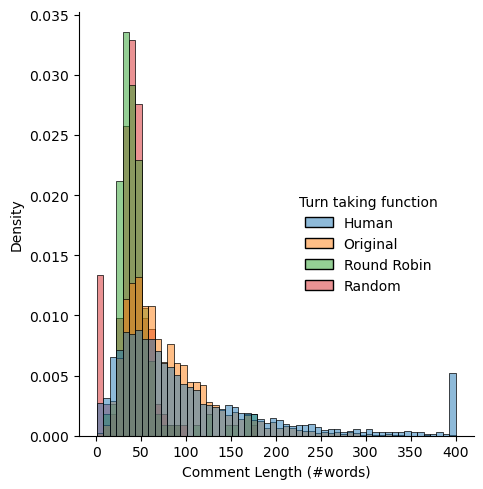

In [12]:
tasks.graphs.comment_len_plot(
    len_df,
    length_col="comment_length",
    feature_col="Turn taking function",
    hue_order=turns_hue_order,
)
tasks.graphs.save_plot(
    tasks.constants.GRAPH_OUTPUT_DIR / "comment_len_turns.png"
)

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/comment_len_model.png


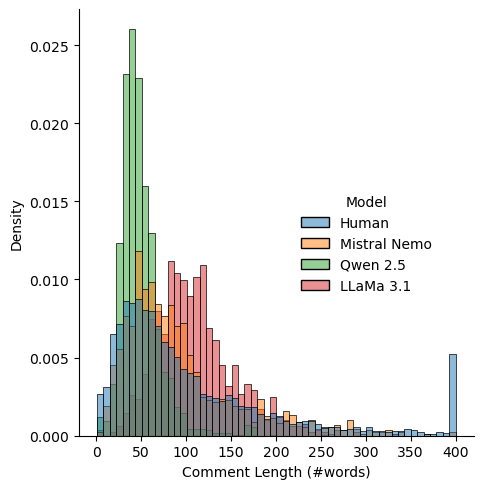

In [13]:
tasks.graphs.comment_len_plot(
    len_df,
    length_col="comment_length",
    feature_col="Model",
    hue_order=model_hue_order,
)
tasks.graphs.save_plot(
    tasks.constants.GRAPH_OUTPUT_DIR / "comment_len_model.png"
)

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/comment_len_prompts.png


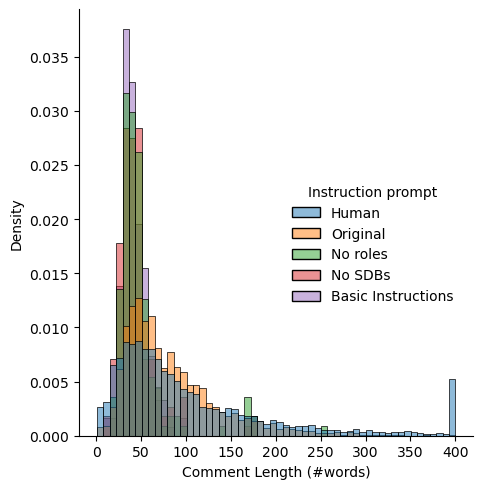

In [14]:
tasks.graphs.comment_len_plot(
    len_df,
    length_col="comment_length",
    feature_col="Instruction prompt",
    hue_order=prompts_hue_order,
)
tasks.graphs.save_plot(
    tasks.constants.GRAPH_OUTPUT_DIR / "comment_len_prompts.png"
)

### Diversity

In [15]:
similarity_df = df.copy()
# delete @ usernames
similarity_df.message = similarity_df.message.apply(
    lambda msg: " ".join(
        word for word in msg.split() if not word.startswith("@")
    )
)
similarity_df = (
    similarity_df.groupby(
        ["conv_id", "Model", "Instruction prompt", "Turn taking function"]
    )["message"]
    .apply(lambda messages: messages.tolist())
    .reset_index()
)
comments_ls = similarity_df["message"].tolist()
similarity_df["rougel_similarity"] = tasks.stats.rougel_similarity(comments_ls)
similarity_df = similarity_df[~similarity_df.rougel_similarity.isnull()]
similarity_df.rougel_similarity.describe()

Computing ROUGE-L similarities:   0%|          | 0/290 [00:00<?, ?it/s]

count    275.000000
mean       0.873937
std        0.062668
min        0.250000
25%        0.835467
50%        0.872151
75%        0.900082
max        0.998940
Name: rougel_similarity, dtype: float64

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/rougel_model.png


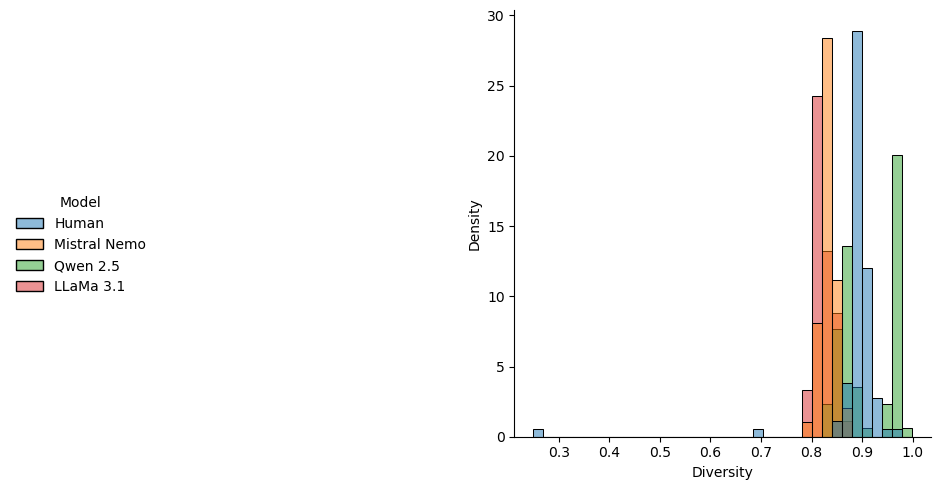

In [16]:
tasks.graphs.rougel_plot(
    df=similarity_df,
    rougel_col="rougel_similarity",
    feature_col="Model",
    hue_order=model_hue_order,
)
tasks.graphs.save_plot(tasks.constants.GRAPH_OUTPUT_DIR / "rougel_model.png")

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/rougel_prompts.png


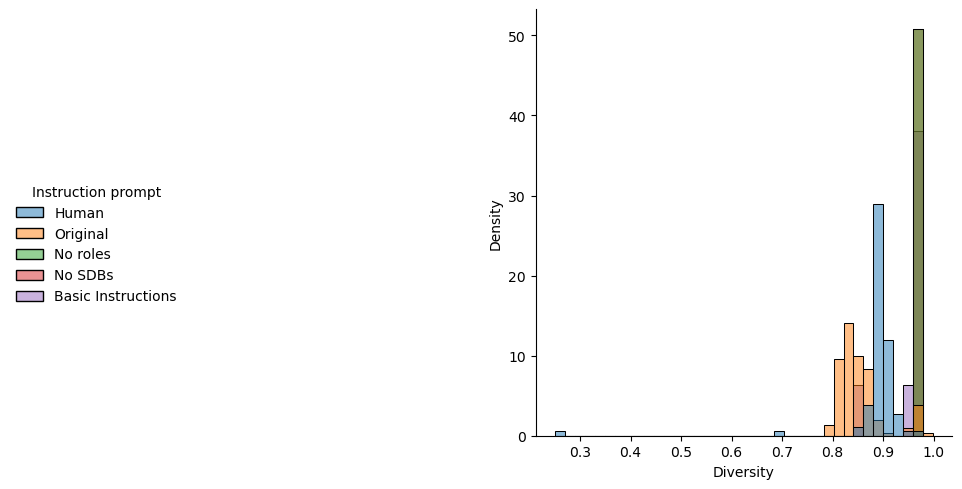

In [17]:
tasks.graphs.rougel_plot(
    df=similarity_df,
    rougel_col="rougel_similarity",
    feature_col="Instruction prompt",
    hue_order=prompts_hue_order,
)
tasks.graphs.save_plot(tasks.constants.GRAPH_OUTPUT_DIR / "rougel_prompts.png")

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/rougel_turns.png


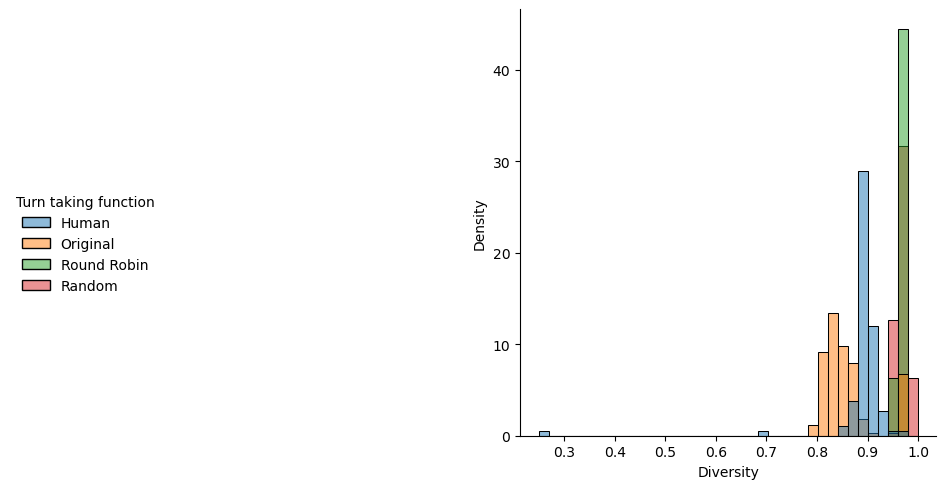

In [18]:
tasks.graphs.rougel_plot(
    df=similarity_df,
    rougel_col="rougel_similarity",
    feature_col="Turn taking function",
    hue_order=turns_hue_order
)
tasks.graphs.save_plot(
    tasks.constants.GRAPH_OUTPUT_DIR / "rougel_turns.png"
)

## Statistical tests

In [19]:
tasks.stats.mean_comp_test(
    df=similarity_df, feature_col="Model", score_col="rougel_similarity"
)

6.925613456020096e-22

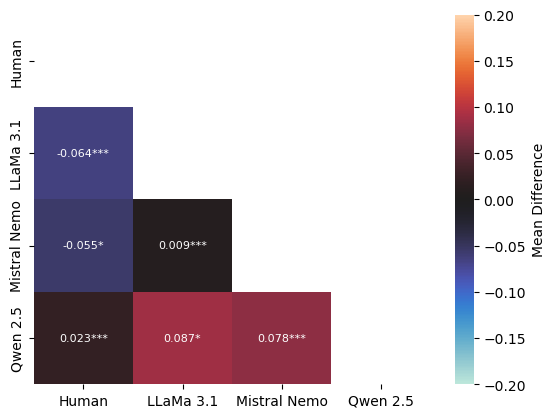

In [20]:
tasks.graphs.posthoc_heatmap(
    similarity_df, "rougel_similarity", group_col="Model", vmin=VMIN, vmax=VMAX
)

In [21]:
tasks.stats.mean_comp_test(
    df=similarity_df,
    feature_col="Instruction prompt",
    score_col="rougel_similarity",
)

1.291370412343254e-16

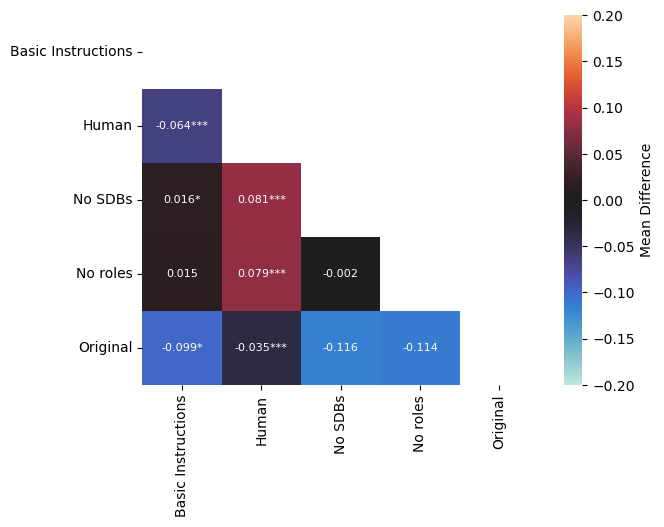

In [22]:
tasks.graphs.posthoc_heatmap(
    similarity_df,
    "rougel_similarity",
    group_col="Instruction prompt",
    vmin=VMIN,
    vmax=VMAX,
)

In [23]:
tasks.stats.mean_comp_test(
    df=similarity_df,
    feature_col="Turn taking function",
    score_col="rougel_similarity",
)

6.782182071085495e-12

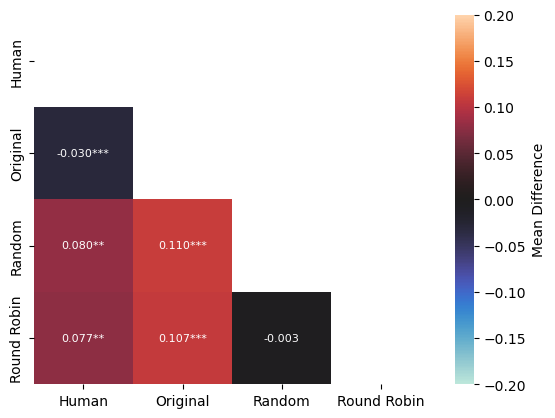

In [24]:
tasks.graphs.posthoc_heatmap(
    similarity_df,
    "rougel_similarity",
    group_col="Turn taking function",
    vmin=VMIN,
    vmax=VMAX,
)

## Diversity x Comment length correlation

In [25]:
conv_len_df = (
    len_df.groupby(["conv_id", "Model"])["comment_length"].sum().reset_index()
)
conv_len_df

,conv_id,Model,comment_length
0,Supporting “personalized health care”,Human,1140
1,01336d04-f98a-46ec-8b1b-1eabd44f369f,Mistral Nemo,1552
2,028f869d-cf12-444a-aefc-62f8b6294acd,Qwen 2.5,710
3,04a24daf-ae9b-48bf-b7c2-c5dcd9252c24,Mistral Nemo,2589
4,0594f5fe-3bef-4642-8bb7-9ac356f44acb,Qwen 2.5,1496
...,...,...,...
284,ffbc33da-dbdb-4408-8df4-6400201ed8af,Mistral Nemo,2468
285,foreign air carriers,Human,929
286,peanut allergies,Human,65295
287,pricing & advertising,Human,7176


In [26]:
corr_df = conv_len_df.merge(
    similarity_df, on="conv_id"
)
corr_df["human"] = corr_df.Model_x == "Human"
corr_df = corr_df.loc[:, ["rougel_similarity", "comment_length", "human"]]
corr_df

,rougel_similarity,comment_length,human
0,0.889082,1140,True
1,0.820413,1552,False
2,0.874538,710,False
3,0.840437,2589,False
4,0.866161,1496,False
...,...,...,...
270,0.839502,2468,False
271,0.854075,929,True
272,0.909839,65295,True
273,0.891412,7176,True


In [27]:
model = smf.ols(
    "rougel_similarity ~ comment_length : C(human)",
    data=corr_df,
)
# Fit the model
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rougel_similarity   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     34.34
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           5.05e-14
Time:                        15:41:15   Log-Likelihood:                 402.97
No. Observations:                 275   AIC:                            -799.9
Df Residuals:                     272   BIC:                            -789.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.9030      0.005    172.632      0.000       0.893       0.913
comment_length:C(human)[False]  -2.38e-05   2.97e-06     -8.021      0.000   -2.96e-05    -1.8e-05
comment_length:C(human)[True]  -2.027e-07   7.08e-07     -0.287      0.775    -1.6e-06    1.19e-06
==============================================================================
Omnibus:                      356.726   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51879.671
Skew:                          -5.572   Prob(JB):                         0.00
Kurtosis:                      69.359   Cond. No.                     8.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""